# Directionality Feature

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Assume the given image be:

In [2]:
np.random.seed(42)
img = np.random.randint(0, 256, (7,7))
img

array([[102, 179,  92,  14, 106,  71, 188],
       [ 20, 102, 121, 210, 214,  74, 202],
       [ 87, 116,  99, 103, 151, 130, 149],
       [ 52,   1,  87, 235, 157,  37, 129],
       [191, 187,  20, 160, 203,  57,  21],
       [252, 235,  88,  48, 218,  58, 254],
       [169, 255, 219, 187, 207,  14, 189]])

### Step I: Quantization

Let's quantization level be 10. It means all the values of iamge which is between [0,255] is converted to range [0, 9]. After that make sure you round off numbers to the nearest natural number. 

<center><font size=5>$Q(img, q\_level): [0, 255] [0, q\_level]$</font></center> 
<br>
<center><font size=5>$Q(img, q\_level) = \frac{img * (q\_level)}{255-0}$</font></center>

In [3]:
q_img  = (img * 10 /255).astype(np.int16) 
q_img

array([[ 4,  7,  3,  0,  4,  2,  7],
       [ 0,  4,  4,  8,  8,  2,  7],
       [ 3,  4,  3,  4,  5,  5,  5],
       [ 2,  0,  3,  9,  6,  1,  5],
       [ 7,  7,  0,  6,  7,  2,  0],
       [ 9,  9,  3,  1,  8,  2,  9],
       [ 6, 10,  8,  7,  8,  0,  7]], dtype=int16)

### Step II: Padding

We have to pad the image with either zeros of the border pixels. This is important because the next step will reduce the length and width of image by 2 pixls units for each dimension.

In [4]:
p_img = np.ones((9, 9)).astype(np.int16)
p_img[1:-1, 1:-1] = q_img

p_img[0, :] = p_img[1, :]
p_img[-1, :] = p_img[-2, :]

p_img[:, 0] = p_img[:, 1]
p_img[:, -1] = p_img[:, -2]

p_img

array([[ 4,  4,  7,  3,  0,  4,  2,  7,  7],
       [ 4,  4,  7,  3,  0,  4,  2,  7,  7],
       [ 0,  0,  4,  4,  8,  8,  2,  7,  7],
       [ 3,  3,  4,  3,  4,  5,  5,  5,  5],
       [ 2,  2,  0,  3,  9,  6,  1,  5,  5],
       [ 7,  7,  7,  0,  6,  7,  2,  0,  0],
       [ 9,  9,  9,  3,  1,  8,  2,  9,  9],
       [ 6,  6, 10,  8,  7,  8,  0,  7,  7],
       [ 6,  6, 10,  8,  7,  8,  0,  7,  7]], dtype=int16)

### Step III: Gradient Calculation

To calcualte the respective gradients we have to perform the simple convolution operation (this is different from what you have done is signal processing). Perform a point wise multiplication between the kernel matrix and the part of quantised image and then repalce the value of central pixel with the sum of all the products that we ahve calculated.

In [5]:
kernel_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
kernel_x

array([[-1,  0,  1],
       [-1,  0,  1],
       [-1,  0,  1]])

In [6]:
kernel_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
kernel_y

array([[-1, -1, -1],
       [ 0,  0,  0],
       [ 1,  1,  1]])

Gradient can be calcualted in this way

<img src = "img1.jpg" style="width:500px;height:600px;"></img>

In the below step I'm justing doing the operation demonstrated above over the whole iamge. This whole operation is sliding the kernel over the image and performing the operation demonstrated above.<br><br>
As we are looking ofr pattern in the x diection and y direction we hav to do this operation with $\Delta X$ and $\Delta Y$ kernels.

In [7]:
del_x = np.ones((7, 7)).astype(np.int16) # length of gradient will be 2 less than the length of original image.
del_y = np.ones((7, 7)).astype(np.int16) # Width of gradient will be 2 less than the width of original image.

for i in range(1,len(p_img)-1):
    for j in range(1,len(p_img)-1):
        del_x[i-1, j-1] = np.sum(p_img[i-1:i+2,j-1:j+2] * kernel_x).astype(np.int16)
        del_y[i-1, j-1] = np.sum(p_img[i-1:i+2,j-1:j+2] * kernel_y).astype(np.int16)
        

In [8]:
# del_x = Conv(padded_image, kernel_x)

print(del_x)

[[ 10   2 -10   6  -2   5  15]
 [  8   3  -3   7  -3   2  10]
 [  3   5  13   9 -13  -2   9]
 [ -1  -6   8  12 -11  -8   2]
 [ -2 -12   0  15 -11  -7   9]
 [  4 -11 -12  12 -10  -7  12]
 [  8  -2 -14   5 -13  -1  21]]


In [9]:
# del_y = Conv(padded_image, kernel_x)

print(del_y)

[[-11  -6   6  13  12   4   0]
 [ -5  -4   1   5   8   2  -1]
 [  0  -3  -4  -2  -2  -5  -5]
 [ 11   4   2   1   1  -6 -13]
 [ 23  16   1  -6  -5   7   9]
 [  1  10  12  10   0   6  12]
 [ -5   3  12  11   4  -4  -6]]


### Step IV: Edge Strength

It is the mean of the absolute value del_x and del_y cacluated in the above steps. I'm using $H$ to represent the edge strength. It basically represents the strength of the edge which connects the adjacent pairs of pixels. 
Example: If you draw an image by hand using pencil, the edge streagth refers to the thickness of the stroke that you use for a particualr position in image.

<center><font size=5>$H = \frac{\Delta x + \Delta y}{2}$</font></center>

In [10]:
H = (np.abs(del_x) + np.abs(del_y))/2
H

array([[10.5,  4. ,  8. ,  9.5,  7. ,  4.5,  7.5],
       [ 6.5,  3.5,  2. ,  6. ,  5.5,  2. ,  5.5],
       [ 1.5,  4. ,  8.5,  5.5,  7.5,  3.5,  7. ],
       [ 6. ,  5. ,  5. ,  6.5,  6. ,  7. ,  7.5],
       [12.5, 14. ,  0.5, 10.5,  8. ,  7. ,  9. ],
       [ 2.5, 10.5, 12. , 11. ,  5. ,  6.5, 12. ],
       [ 6.5,  2.5, 13. ,  8. ,  8.5,  2.5, 13.5]])

### Step V: Directionality Angle

The next step is to cacualte the angle between the del_x and del_y. del_x corrosponds to horizintal edges in image and del_y corrospnds to vertical edges in image. to get the ange we hae to divide del_x by del_y and calcualte the inverse tangent of result. We will get the vaue in range [-$\pi$/2,$\pi$/2]. To convert the range into [0, $\pi$] we add $\pi$/2 to all the indices of the received array. I'm denoting this result as $\alpha$.

<center><font size=5>$\alpha = \frac{\pi}{2} + tan^{-1}\frac{\Delta x}{\Delta y}$</font></center>

The above operation is a point wise operation.

In [11]:
alpha = np.arctan(del_x/del_y) + (np.pi/2)

c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


The result that we have received ie. $\alpha$ is in $radian$. Let's convert it in degress and check the ranges of the angles that we are getting. This is just for demonstration, you're not supposed to do this during written test.

In [12]:
alpha_degree = alpha * (180/np.pi)
np.around(alpha_degree, 2)

array([[ 47.73,  71.57,  30.96, 114.78,  80.54, 141.34, 180.  ],
       [ 32.01,  53.13,  18.43, 144.46,  69.44, 135.  ,   5.71],
       [180.  ,  30.96,  17.1 ,  12.53, 171.25, 111.8 ,  29.05],
       [ 84.81,  33.69, 165.96, 175.24,   5.19, 143.13,  81.25],
       [ 85.03,  53.13,  90.  ,  21.8 , 155.56,  45.  , 135.  ],
       [165.96,  42.27,  45.  , 140.19,   0.  ,  40.6 , 135.  ],
       [ 32.01,  56.31,  40.6 , 114.44,  17.1 , 104.04,  15.95]])

We can observe that all the values are between the range 0 and 180.

# Step VI: Histogram

In this step we have to plot histogram for $H$ and $\alpha$. The histogram for $\alpha$ is relatively uniform for images without strong orientation and exhibits peaks for highly directional images. The histogram for $H$ represents the distribution of the different edge weights. 

We can quantise the values of $\alpha$ and $H$ matrixes before plotting histograms.

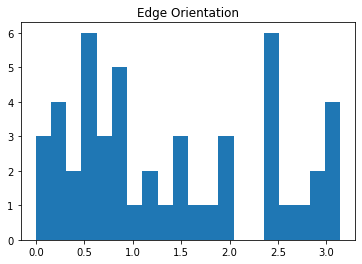

In [13]:
plt.hist(alpha.reshape(-1), bins=20)
plt.title("Edge Orientation")
plt.show()

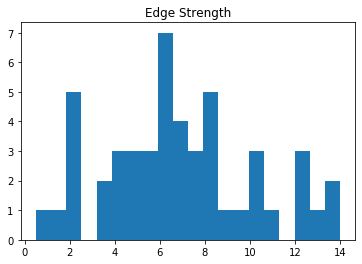

In [14]:
plt.hist(H.reshape(-1), bins=20)
plt.title("Edge Strength")
plt.show()

# Observations

Text(0.5, 1.0, 'Edge Strength Matrix')

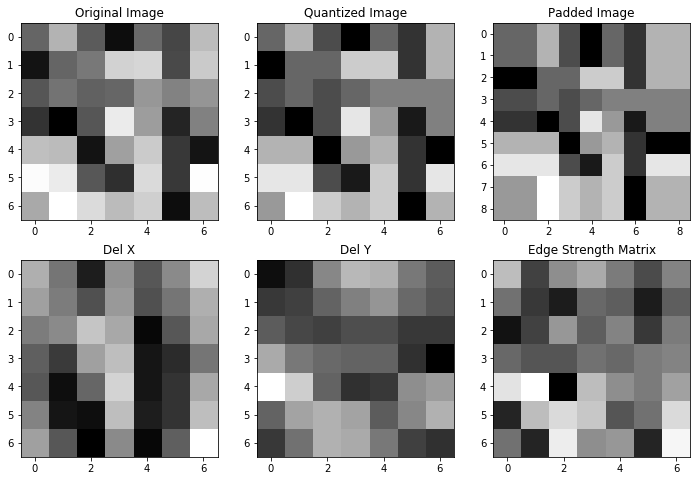

In [15]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(img, cmap="gray")
plt.title("Original Image")

plt.subplot(2, 3, 2)
plt.imshow(q_img, cmap="gray")
plt.title("Quantized Image")

plt.subplot(2, 3, 3)
plt.imshow(p_img, cmap="gray")
plt.title("Padded Image")

plt.subplot(2, 3, 4)
plt.imshow(del_x, cmap="gray")
plt.title("Del X")

plt.subplot(2, 3, 5)
plt.imshow(del_y, cmap="gray")
plt.title("Del Y")

plt.subplot(2, 3, 6)
plt.imshow(H, cmap="gray")
plt.title("Edge Strength Matrix")